# ImpDAR Precision GPS Time Offset Tutorial

### Introduction

**Interpolation:**
Logs trace and gps points, spreads out information over line for continuous data (mention precision gps vs attached gps)

**GPS:**
The gecko reader in StoDeep does not use the .gps file as far as I can tell, and neither do I. There is some geographic information in the trace headers, and this is what I use instead. This is nice for a sanity check with your precision GPS, so you can make sure you are correctly locating it, but it should not matter since we really just use the timestamps for `impdar interp`.

Some radars will require GPS, some will not. Some of the systems effectively predate GPS, while others have no need for it. For example, geotechnical applications like finding pipes etc. do not necessarily require any positioning, or they may use a survey wheel, so dealing with an external GPS is just an unnecessary hassle. Some glaciologists will just sync the clock on their radar to GPS time at the beginning of the data collection, then run a precision GPS entirely separately from the radar, and attach the post-processed gps data (with the equivalent of `impdar interp`) at processing. ImpDAR should be flexible with all of this—you cannot convert to make your x-axis distance if you don’t have spatial information, but impdar will let you do most filtering and cropping, and it will still let you pick, even with no GPS.

**Precision GPS:**
Precision gps is quality measurements for (x, y, z). There is also a GPS attached to the antenna that takes (x, y, z, t) measurement. The (x, y, z) data from this GPS is not high quality, so we take the (t) from the attached gps and use the (x, y, z) from the precision GPS. This step needs to be taken only during the interpolation step, all of the other processing steps don’t need it.

“As we discussed, the precision GPS will normally not be connected by hardware to the radar system. This will not always be the case (and when it is not the interpolation could be done as you were doing straight off of the radar file). There are some reasons for this but the easiest explanation is that the computer gets confused when it is trying to store so much in memory (GPS is recording a location every second and the radar is stacking hundreds of traces every couple of seconds ).”


**Spacing:**
Antenna separation at HD is 171.4 m. This is something that you have to measure in the field. I think that there might be a way to save it in the Gecko file, but we did not do that. Generally, you just need to ask the person who was in the field. Interpolation should be to a trace spacing that is larger than the original trace separation, but not too much. We have been using 3 m which seems to work well. To answer your question more directly though, no it doesn't really matter what this is.

In [1]:
import numpy as np

from scipy.io import loadmat
from scipy.io import savemat

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import mode
from scipy.interpolate import interp1d

import impdar
from impdar.lib import load
from impdar.lib import plot
from impdar.lib import gpslib

### Load and Inspect the Data

In [2]:
#input and output files for loading and saving
#herc_gps_in_file = 'HD_precisionGPS_2018_Day3_mod.mat'
gps_file = '../data/HD_precisionGPS_2018_Day3_mod.mat'

herc_file = '../data/HDGridE_x53_cropped_nmo_bandpassed_mod.mat'

#load in precision gps file
gps = loadmat(gps_file)

#load in scg data line
dat = load.load('mat', herc_file)[0]

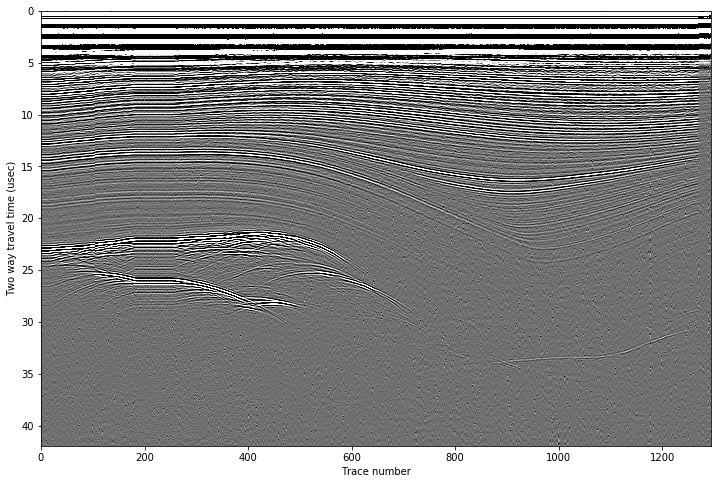

In [3]:
plot.plot_radargram(dat)
plt.show()

In [4]:
print(gps.keys())

dict_keys(['__header__', '__version__', '__globals__', 'gpsdata', 'year', 'day', 's', 'lat', 'long', 'elev', 'decday', 'x_coord', 'y_coord', 'px', 'py'])


In [5]:
for k, v in vars(dat).items():
    print('\'{}\':'.format(k), v)

'chan': 2
'data': [[11136  9968 20721 ...  9009 -2811 -1902]
 [10101  8974 20058 ... 11453 -2688 -1726]
 [ 9115  8040 19285 ... 13762 -2554 -1540]
 ...
 [   -2    -2    -2 ...    -1    -1     1]
 [   -2    -2    -1 ...    -1    -1     1]
 [   -1    -2    -1 ...    -1    -1     1]]
'decday': [737088.07123351 737088.07126144 737088.07128971 ... 737088.10798595
 737088.10801412 737088.10804241]
'dt': 5e-09
'lat': [-86.44215833 -86.44216167 -86.44215833 ... -86.413815   -86.413795
 -86.41375167]
'long': [252.936615   252.93663333 252.93665    ... 251.76821    251.76731167
 251.76551333]
'pressure': [0 0 0 ... 0 0 0]
'snum': 8192
'tnum': 1294
'trace_int': [0 0 0 ... 0 0 0]
'trace_num': [   1    2    3 ... 1292 1293 1294]
'travel_time': [0.00000000e+00 5.12232269e-03 1.02446454e-02 ... 4.19467005e+01
 4.19518228e+01 4.19569451e+01]
'trig': 0
'trig_level': [50 50 50 ... 50 50 50]
'nmo_depth': [0.00000000e+00 4.32836267e-01 8.65672534e-01 ... 3.54449619e+03
 3.54492903e+03 3.54536186e+03]
'ele

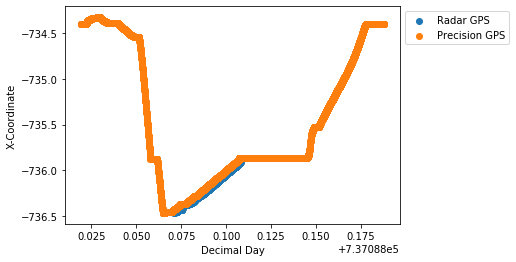

In [6]:
#plot decday vs x_coord variables for radar and precision gps
plt.scatter(dat.decday, dat.x_coord/1000, label='Radar GPS')
plt.scatter(gps['decday'], gps['x_coord']/1000, label='Precision GPS')

#add x and y labels
plt.xlabel('Decimal Day')
plt.ylabel('X-Coordinate')

#put legend on the side of the plot
plt.legend(bbox_to_anchor=(1., 1.))

plt.show()

In [7]:
"""
We need to make sure that the two variables are close, otherwise we should stop the method.
Check that mwindow is a float
"""
def find_dt_offset(gps, radar, decday_var='decday', compare_var='lat', mwindow=1.):

    #we need to make our RadarData object subscriptable
    #otherwise the syntax dat['decday'] throws the error: TypeError: 'RadarData' object is not subscriptable
    radar_dict = dict(vars(radar).items())
    
    #make copies of time and x-coordinate arrays from radar
    t_radar = radar_dict[decday_var].copy()
    y_radar = radar_dict[compare_var].copy()

    #calculate rate of change for radar time
    dt_radar = mode(np.gradient(t_radar))[0][0]

    #make copies of time and x-coordinate arrays from precision gps
    t_gps = np.squeeze(gps[decday_var]).copy()
    y_gps = np.squeeze(gps[compare_var]).copy()

    #creating a function that will resample data points 
    interp = interp1d(t_gps,y_gps,fill_value='extrapolate')

    #creating new precision gps arrays from dt_radar
    t_gps_new = np.arange(t_gps[0],t_gps[-1],dt_radar)
    y_gps_new = interp(t_gps_new)

    #empty list to save cross-correlation values
    xcorr_listy = np.zeros(len(t_gps_new)-len(t_radar))

    #iterate trough the precision gps array for a time step of 1 
    #until we have gone through all of the data
    for i in range(len(t_gps_new)-len(t_radar)):
        minutes_to_days = 1./(24.*60.)
        minute_window = mwindow

        if np.abs(t_gps_new[i] - t_radar[0]) < minute_window*minutes_to_days:
            tempy = y_gps_new[i:i+len(y_radar)]
            #Covariance matrix: subset for gps-radar: [[gps-gps, gps-radar], [radar-gps, radar-radar]]
            xcorry = abs(np.corrcoef(y_radar, tempy)[0, 1])
            #append to xcorr to list
            xcorr_listy[i] = xcorry

    #calculate offset
    offset = t_radar[0] - t_gps_new[np.argmax(xcorr_listy)]
    
    #print the offset to the user
    print('The decday time offset is: {}'.format(offset))
    
    #returrn the offset value for further use
    return offset

In [8]:
"""
Make sure that the offset is a float
That add or subtract is a string
That saveas is a string
that limitx and limit y both are of type list, contain at least one number, which are floats
"""
def plot_offset(gps, radar, offset, decday_var='decday', compare_var='lat', limitx=None, limity=None):
    #set figure and axis for subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 8))
    
    #we need to make our RadarData object subscriptable
    #otherwise the syntax dat['decday'] throws the error: TypeError: 'RadarData' object is not subscriptable
    radar_dict = dict(vars(radar).items())

    #plot full scale of gps and radar data for the compare_var variable
    ax[0].scatter(np.squeeze(gps[decday_var]), np.squeeze(gps[compare_var]), s=1)
    ax[0].scatter(np.squeeze(radar_dict[decday_var]), np.squeeze(radar_dict[compare_var]), label='original', s=1)

    #plot full second plot of gps and radar data to zoom in
    ax[1].scatter(np.squeeze(gps[decday_var]), np.squeeze(gps[compare_var]), s=1)
    ax[1].scatter(np.squeeze(radar_dict[decday_var]), np.squeeze(radar_dict[compare_var]), label='original', s=1)
    
    #take absolute value of the time offset, so that we can always subtract it
    offset = np.abs(offset)
    
    #subtract the offset
    ax[0].scatter(np.squeeze(radar_dict[decday_var]-offset), np.squeeze(radar_dict[compare_var]), label='shifted', s=1)
    ax[1].scatter(np.squeeze(radar_dict[decday_var]-offset), np.squeeze(radar_dict[compare_var]), label='shifted', s=1)
        
    #set axis limits if the user inputs them
    if limitx != None:
        ax[1].set_xlim(limitx[0], limitx[1])
        
    if limity != None:
        ax[1].set_ylim(limity[0], limity[1])

    #add axis labels; the xlabel is shared between the subplots
    ax[0].set_ylabel(compare_var, fontsize=18)
    fig.text(0.5, 0.04, decday_var, ha='center', fontsize=18)
    
    #set title
    plt.suptitle('Time offset for the precision gps and radar using the variable: {}'.format(compare_var), fontsize=16, y=0.95)
    
    #set legends for both subplots
    ax[0].legend()
    ax[1].legend()
        
    plt.show()

The decday time offset is: 0.0006795721128582954


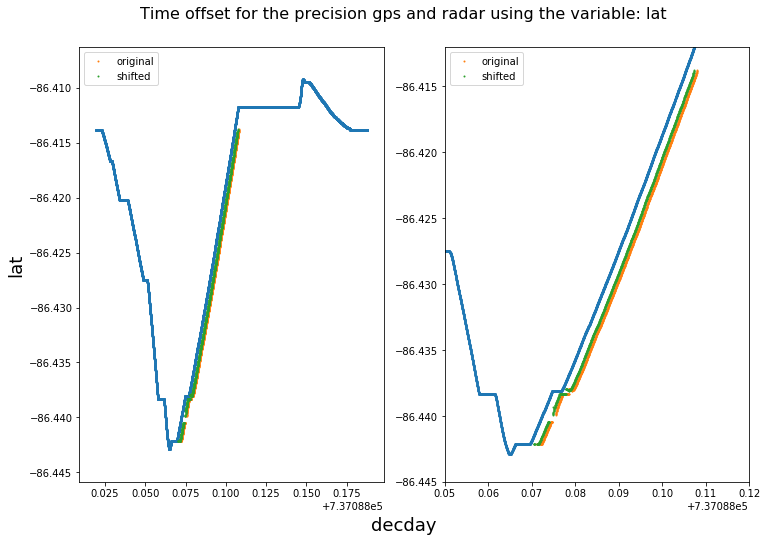

In [9]:
offset_lat = find_dt_offset(gps, dat, compare_var='lat', mwindow=1.)

plot_offset(gps, dat, offset_lat, 'decday', 'lat', limitx=[0.05+7.37088e5, 0.12+7.37088e5], limity=[-86.445, -86.412])

We should get the same time offset if we compare the `lat` and `x_coord` data attributes.

The decday time offset is: 0.0006795721128582954


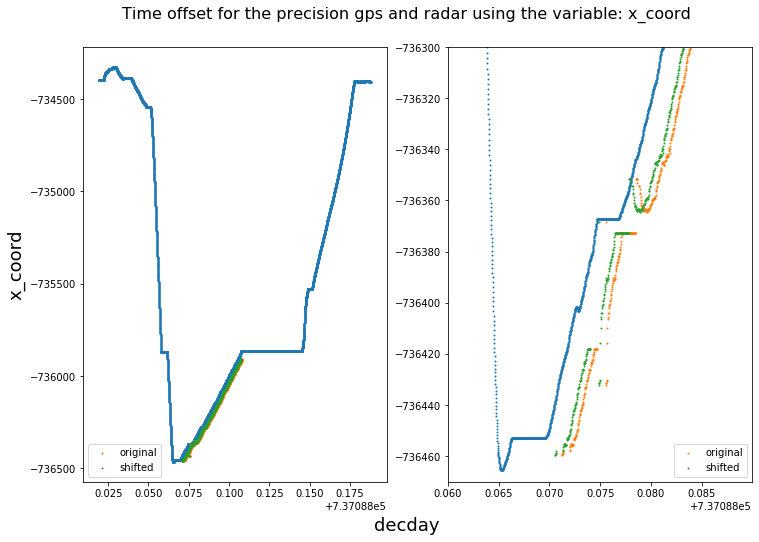

In [10]:
offset_x = find_dt_offset(gps, dat, compare_var='x_coord', mwindow=1.)

plot_offset(gps, dat, offset_x, compare_var='x_coord', limitx=[0.060+7.37088e5, 0.090+7.37088e5], limity=[-736470, -736300])

In [11]:
assert(offset_lat == offset_x)

### Interpolation

We can then interpolate and migrate this data, which is much closer to a finished data-produt. To do that from the command line, we can run:

```python
impproc interp --gps_fn HD_precisionGPS_2018_Day3_mod.mat 3 --offset 0.0006795721128582954 --minmove 0.001 HDGridE_x53_cropped_nmo_bandpassed.mat

impproc migrate --mtype su --sutype sumigtk HDGridE_x53_nmo_cropped_bandpassed_interp.mat
```

But we can also do the same thing in our Jupyter Notebook and then save the file.

**Note**: this does not work! When running the interp function from the command line, I get the following error:

```
Traceback (most recent call last):
  File "/home/jakidxav/anaconda3/bin/impproc", line 11, in <module>
    load_entry_point('impdar', 'console_scripts', 'impproc')()
  File "/home/jakidxav/ImpDAR/impdar/bin/impproc.py", line 164, in main
    interp(radar_data, **vars(args))
  File "/home/jakidxav/ImpDAR/impdar/bin/impproc.py", line 234, in interp
    interpdeep(dats, spacing, fn=gps_fn, offset=offset, min_movement=minmove, extrapolate=extrapolate)
  File "/home/jakidxav/ImpDAR/impdar/lib/gpslib.py", line 346, in interp
    kinematic_gps_mat(dats, fn, offset=offset, extrapolate=extrapolate, guess_offset=guess_offset)
  File "/home/jakidxav/ImpDAR/impdar/lib/gpslib.py", line 290, in kinematic_gps_mat
    kinematic_gps_control(dats, mat['lat'].flatten(), mat['long'].flatten(), mat['elev'].flatten(), mat['decday'].flatten(), offset=offset, extrapolate=extrapolate, guess_offset=guess_offset)
  File "/home/jakidxav/ImpDAR/impdar/lib/gpslib.py", line 255, in kinematic_gps_control
    dat.lat = int_lat(dat.decday)
  File "/home/jakidxav/anaconda3/lib/python3.6/site-packages/scipy/interpolate/polyint.py", line 79, in __call__
    y = self._evaluate(x)
  File "/home/jakidxav/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py", line 663, in _evaluate
    below_bounds, above_bounds = self._check_bounds(x_new)
  File "/home/jakidxav/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py", line 695, in _check_bounds
    raise ValueError("A value in x_new is above the interpolation "
ValueError: A value in x_new is above the interpolation range.

```

In [12]:
gpslib.interp([dat], interp=True, gps_fn=gps_file, offset=offset_x, minmove=0.001, spacing=3)

MemoryError: 